# Teste com K-Means

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [19]:
def showfig(image):
    plt.figure(figsize=(6,6))
    plt.imshow(image,'gray')

#%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

params = {'figure.figsize': [7, 7], 
          'axes.titlesize':16, 
          'font.size': 16,
          'legend.fontsize': 12, 
          'xtick.labelsize': 12, 
          'ytick.labelsize': 8
         }
plt.rcParams.update(params)

In [20]:
def region_of_interest(img):
    height = img.shape[0]
    width = img.shape[1]
    mask = np.ones_like(img)*255

    poly = np.array([[  # Polígono para fazer a máscara (feito sob medida da)
    (0,0),
    (width,0),
    (width,210),
    (0,210),]], np.int32)
    masked=cv2.fillPoly(mask, poly,0) #return none --> preenche a região
    masked_image = cv2.bitwise_and(img, mask) #Ou exclusivo para ignorar oq estiver fora da mask
    return masked_image

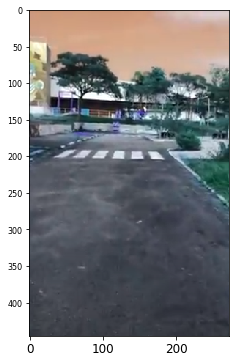

In [21]:
pista =cv2.imread('pista.png')
showfig(pista)

In [22]:
#creating empty image of same size
image = cv2.GaussianBlur(pista,(15,15),0)  
height, width, no_use = image.shape
empty_img = np.zeros((height, width), np.uint8)  ## Fazer uma cópia das dimensões da imagem

#APPLY K-MEANS CLUSTERING:
#flatten the image
Z = image.reshape((-1,3)) 
# need to convert to np.float32  
Z = np.float32(Z)
# define criteria, 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,15, 1.0)  # type, max iteration, epsilon
K = 4 # number of clusters required(K)   -- Episilon = required accuracy
flags = cv2.KMEANS_RANDOM_CENTERS
ret,label,center=cv2.kmeans(Z,K,None,criteria,15,flags) # apply kmeans()
# Args:  Attempts - Number of initializations to get the best compactiness
# Flags: can be  cv2.KMEANS_PP_CENTERS or cv2.KMEANS_RANDOM_CENTERS

#OUTPUTS: Compactiness d^2 of the centers , label array, centers

# Now convert back into uint8, and make original image  # Reconstruct image
center = np.uint8(center)
res = center[label.flatten()]  # Reconstruct the image data
res2 = res.reshape((image.shape))

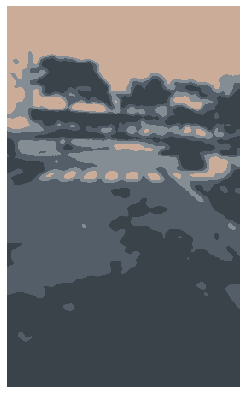

In [23]:
plt.imshow(res2)
plt.axis("off")
plt.savefig("Imagens\kmeans1.pdf")


In [24]:
#CONVERTED TO A LUV IMAGE AND MADE EMPTY IMAGE, A MASK
blur = cv2.GaussianBlur(res2,(15,15),0)  
kernel = np.ones((3,3),np.uint8)
blur = cv2.morphologyEx(blur,cv2.MORPH_CLOSE,kernel, iterations = 3) 

gray = cv2.cvtColor(blur,cv2.COLOR_RGB2GRAY)
LUV = cv2.cvtColor(blur,cv2.COLOR_RGB2LUV)
l = LUV[:,:,0]
v1 = l>80
v2 = l<150
value_final = v1 & v2 
empty_img[value_final] = 255
empty_img[LUV[:,:100,:]] = 0
final_masked = cv2.line(empty_img,(40,height),(400,height),255,160)
final_mask = region_of_interest(final_masked)

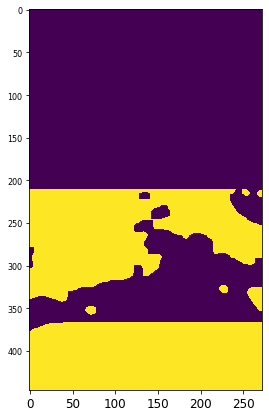

In [25]:
# final_flood = final_masked.copy()
# h, w = final_masked.shape[:2]
# mask = np.zeros((h+2, w+2), np.uint8)
# cv2.floodFill(final_flood,mask,(0,0),255)
# final_flood = cv2.bitwise_not(final_flood)
# final_filled= cv2.bitwise_or(final_masked,final_flood)
# plt.imshow(image)
plt.imshow(final_mask)
plt.savefig("Imagens\kmeans_mask.pdf")


In [26]:
#APPLIED BITWISE-AND ON GRAYSCALE IMAGE AND EMPTY IMAGE TO OBTAIN ROAD AND SOME-OTHER IMAGES TOO
# final = cv2.bitwise_and(gray,empty_img)
# final, contours, hierchary = cv2.findContours(final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# final = cv2.drawContours(final, contours, -1, 0, 3)
# plt.imshow(final)

In [27]:
   #FURTHER MASKED THE FINAL IMAGE TO OBTAIN ONLY THE ROAD PARTICLES
# final_masked = np.zeros((height, width), np.uint8)
# v1 = final >=91
# v2 = final <=130
# #v3 = final == 78    
# final_masked[v1 & v2] = 255
# plt.imshow(v1)
# plt.imshow(final_masked)

In [28]:
# Apply MORPHOLOGICAL PROCESSING
# final_eroded = cv2.erode(final_masked,kernel,iterations=1) 
# final_eroded, contours, hierchary = cv2.findContours(final_eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# final_masked = cv2.drawContours(final_eroded, contours, -1, 0, 3)

# final_waste = cv2.morphologyEx(final_masked,cv2.MORPH_TOPHAT,kernel, iterations = 2) 
# #Aplicação de TOPHAT
# final_waste = cv2.bitwise_not(final_waste)
# final_masked = cv2.bitwise_and(final_waste,final_masked)


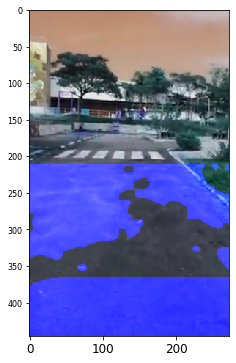

In [29]:
# #MADE A LINE ON THE LEFT-BOTTOM OF THE PAGE
# final_masked = cv2.line(final_masked,(40,height),(400,height),255,120)
# #final_masked = cv2.line(final_masked,(width-300,height),(width,height),255,70)



# #USED FLOOD-FILL TO FILL IN THE SMALL BLACK LANES
# final_flood = final_masked.copy()
# h, w = final_masked.shape[:2]
# mask = np.zeros((h+2, w+2), np.uint8)
# cv2.floodFill(final_flood,mask,(0,0),255)
# final_flood = cv2.bitwise_not(final_flood)
# final_filled= cv2.bitwise_or(final_masked,final_flood)
#final = np.array([np.zeros(final_mask.shape),np.zeros(final_mask.shape),final_mask])
#plt.imshow(final_mask)
array = np.zeros_like(pista)
for i in range (array.shape[0]):
    for j in range (array.shape[1]):
        array[i,j,2] = final_mask[i,j]

combo = cv2.addWeighted(pista,0.9,array,0.8,1)
showfig(combo)
plt.savefig("Imagens\kmeans_final.pdf")


In [30]:
M = cv2.moments(final_mask)

# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

# put text and highlight the center
circle = np.zeros_like(pista)
cv2.circle(circle, (cX, cY), 5, (255, 255, 255), -1)
cv2.putText(circle, "centroide", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

#write the lines
cv2.line(circle, (cX,cY), (int(pista.shape[1]/2),pista.shape[0]),(255,0,0),2)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [31]:
int(pista.shape[1]/2),pista.shape[0]
cX,cY
#m = (y-y0)/(x-x0)  = tan(theta)
rad= np.arctan((cY-pista.shape[0])/(cX-int(pista.shape[1]/2)))
print(rad) # radians?
theta= np.degrees(rad)
cv2.putText(circle, "Direction: %.5s graus"%theta, (25, 50),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2);

1.4659193880646628


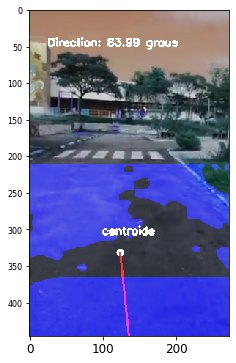

In [32]:

combo2 = cv2.addWeighted(combo,0.9,circle,1,0)
showfig(combo2)
plt.savefig("Imagens\kmeans_final.pdf")
